In [51]:
#https://github.com/sahudevansh/Stock-price-prediction-using-sentiment-analysis-and-GANs
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('apple_stocks_with_sentiment10.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

        Date      Open      High       Low     Close      Volume      NASDAQ   \
0 2010-07-02  8.946072  8.961785  8.685715  8.819285   693842800  2091.790039   
1 2010-07-06  8.964286  9.028571  8.791429  8.879642   615235600  2093.879883   
2 2010-07-07  8.946072  9.241786  8.919642  9.238214   654556000  2159.469971   
3 2010-07-13  9.154285  9.157143  8.801071  8.992857  1190924000  2242.030029   
4 2010-07-14  8.906428  9.135715  8.892858  9.026072   812047600  2249.840088   

         NYSE       S&P 500  FTSE100  ...    HENG SENG          SSE  \
0  6434.810059  1022.580017  4838.09  ...  19905.32031  2382.900879   
1  6486.089844  1028.060059  4965.00  ...  20084.11914  2409.424072   
2  6685.779785  1060.270020  5014.82  ...  19857.07031  2421.116943   
3  6907.779785  1095.339966  5271.02  ...  20431.06055  2450.284912   
4  6903.359863  1095.170044  5253.52  ...  20560.81055  2470.439941   

   Crude Oil         Gold        VIX  USD index      Amazon      Google  \
0  72.13999

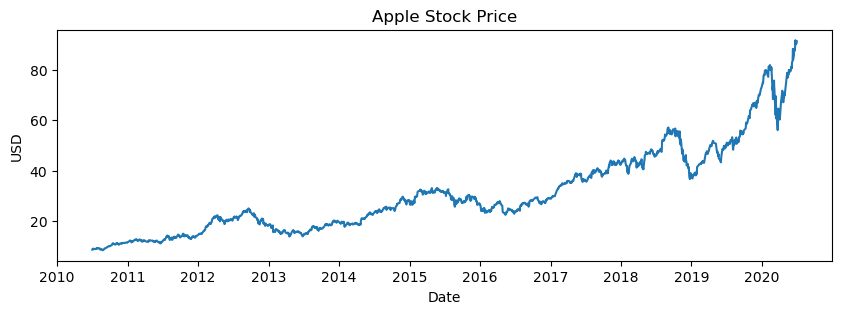

In [3]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Apple stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Apple Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [4]:
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)


In [5]:
dataset = T_df.iloc[20:,:].reset_index(drop=True)

#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [6]:
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [7]:
Final_data

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2010-08-18,9.012857,9.095357,8.985000,9.038215,339696000,2215.699951,6968.080078,1094.160034,5302.87,...,9.508660,8.744979,9.011369,2.084207,40.134485,-0.042983,45.078656,-0.056658,44.291085,-0.024416
1,2010-08-19,9.030000,9.052857,8.881429,8.924286,426706000,2178.949951,6850.450195,1075.630005,5211.29,...,9.507673,8.755967,8.953314,2.069932,40.016973,-0.043172,44.728120,-0.057448,43.717918,-0.024566
2,2010-08-20,8.906786,9.068571,8.892858,8.915714,384230000,2179.760010,6813.149902,1071.689941,5195.28,...,9.519972,8.747103,8.928247,2.068850,39.899294,-0.043359,44.376369,-0.058231,43.144370,-0.024699
3,2010-08-23,8.992500,9.000000,8.758928,8.778571,414041600,2159.629883,6784.970215,1067.359985,5234.84,...,9.524852,8.698448,8.828463,2.051373,39.781451,-0.043542,44.023459,-0.059007,42.570617,-0.024817
4,2010-08-26,8.766071,8.776786,8.581429,8.581429,466505200,2118.689941,6665.259766,1047.219971,5155.84,...,9.568934,8.615181,8.663774,2.025702,39.663449,-0.043723,43.669445,-0.059775,41.996836,-0.024917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,2020-06-22,87.834999,89.864998,87.787498,89.717499,135445200,10056.480470,12028.910160,3117.860107,6244.62,...,90.789591,76.496598,89.000410,4.485457,40.719392,-0.042001,46.811219,-0.052622,47.145001,-0.023452
1992,2020-06-23,91.000000,93.095001,90.567497,91.632500,212155600,10131.370120,12077.740230,3131.290039,6320.12,...,91.803814,76.616661,90.755137,4.506813,40.602778,-0.042203,46.467570,-0.053440,46.576398,-0.023672
1993,2020-06-24,91.250000,92.197502,89.629997,90.014999,192623200,9909.169922,11726.540040,3050.330078,6123.69,...,92.333427,77.118715,90.261712,4.488805,40.485976,-0.042402,46.122435,-0.054253,46.006528,-0.023879
1994,2020-06-29,88.312500,90.542503,87.820000,90.445000,130646000,9874.150391,11777.080080,3053.239990,6225.77,...,92.776329,77.715574,90.383904,4.493624,40.368990,-0.042598,45.775868,-0.055061,45.435567,-0.024072


In [8]:
dataset=Final_data.copy()

In [9]:
# Replace 0 by NA
dataset.replace(0, np.nan, inplace=True)
# dataset.to_csv("dataset.csv", index=False)
# Add News data
# dataset["News"] = news["Score"]

# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ ', 'NYSE ',
       'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000',
       'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon',
       'Google', 'Microsoft', 'stock_tweets', 'MA7', 'MA21', 'MACD', '20SD',
       'upper_band', 'lower_band', 'EMA', 'logmomentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp'],
      dtype='object')


In [10]:
# Set the date to datetime data
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
#dataset excluding 2020
# dataset = dataset.loc[dataset['Date']< '2020-01-01']
dataset = dataset.drop(columns='Date')

In [11]:
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])

In [12]:
X_value

,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,NIKKI225,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
2010-08-18,9.012857,9.095357,8.985000,9.038215,339696000.0,2215.699951,6968.080078,1094.160034,5302.87,9240.540039,...,9.508660,8.744979,9.011369,2.084207,40.134485,-0.042983,45.078656,-0.056658,44.291085,-0.024416
2010-08-19,9.030000,9.052857,8.881429,8.924286,426706000.0,2178.949951,6850.450195,1075.630005,5211.29,9362.679688,...,9.507673,8.755967,8.953314,2.069932,40.016973,-0.043172,44.728120,-0.057448,43.717918,-0.024566
2010-08-20,8.906786,9.068571,8.892858,8.915714,384230000.0,2179.760010,6813.149902,1071.689941,5195.28,9179.379883,...,9.519972,8.747103,8.928247,2.068850,39.899294,-0.043359,44.376369,-0.058231,43.144370,-0.024699
2010-08-23,8.992500,9.000000,8.758928,8.778571,414041600.0,2159.629883,6784.970215,1067.359985,5234.84,9116.690430,...,9.524852,8.698448,8.828463,2.051373,39.781451,-0.043542,44.023459,-0.059007,42.570617,-0.024817
2010-08-26,8.766071,8.776786,8.581429,8.581429,466505200.0,2118.689941,6665.259766,1047.219971,5155.84,8906.480469,...,9.568934,8.615181,8.663774,2.025702,39.663449,-0.043723,43.669445,-0.059775,41.996836,-0.024917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-22,87.834999,89.864998,87.787498,89.717499,135445200.0,10056.480470,12028.910160,3117.860107,6244.62,22437.269530,...,90.789591,76.496598,89.000410,4.485457,40.719392,-0.042001,46.811219,-0.052622,47.145001,-0.023452
2020-06-23,91.000000,93.095001,90.567497,91.632500,212155600.0,10131.370120,12077.740230,3131.290039,6320.12,22549.050780,...,91.803814,76.616661,90.755137,4.506813,40.602778,-0.042203,46.467570,-0.053440,46.576398,-0.023672
2020-06-24,91.250000,92.197502,89.629997,90.014999,192623200.0,9909.169922,11726.540040,3050.330078,6123.69,22534.320310,...,92.333427,77.118715,90.261712,4.488805,40.485976,-0.042402,46.122435,-0.054253,46.006528,-0.023879
2020-06-29,88.312500,90.542503,87.820000,90.445000,130646000.0,9874.150391,11777.080080,3053.239990,6225.77,21995.039060,...,92.776329,77.715574,90.383904,4.493624,40.368990,-0.042598,45.775868,-0.055061,45.435567,-0.024072


In [13]:
y_value

,Close
2010-08-18,9.038215
2010-08-19,8.924286
2010-08-20,8.915714
2010-08-23,8.778571
2010-08-26,8.581429
...,...
2020-06-22,89.717499
2020-06-23,91.632500
2020-06-24,90.014999
2020-06-29,90.445000


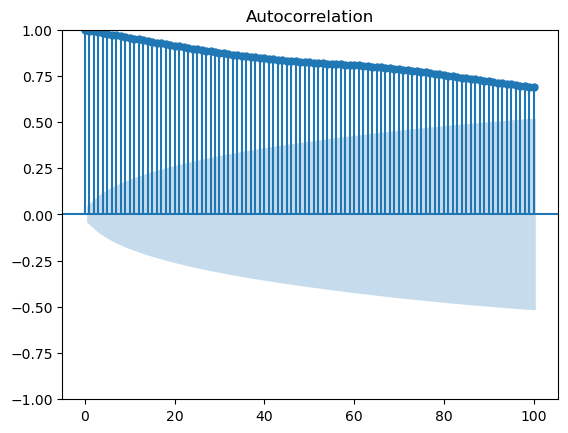

In [17]:

sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()

In [20]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [21]:
# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index
    np.save("train_predict_index.npy", train_predict_index)
    np.save("test_predict_index.npy", test_predict_index)
    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.736)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
# %% --------------------------------------- Save dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)


X shape:  (1993, 3, 36)
y shape:  (1993, 1)
X_train shape:  (1467, 3, 36)
y_train shape:  (1467, 1)
y_c_train shape:  (1467, 3, 1)
X_test shape:  (526, 3, 36)
y_test shape:  (526, 1)
y_c_test shape:  (526, 3, 1)
index_train shape: (1467,)
index_test shape: (526,)


In [29]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net


model = make_discriminator_model()
print(model.summary())


class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.learning_rate = opt["learning_rate"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        print(real_x.shape)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2, 32)             128       
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 64)             10304     
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 128)            41088     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 220)               28160     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 220)               0         
                                                                 
 dense_16 (Dense)            (None, 220)              

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 3, 1024)           3262464   
                                                                 
 gru_7 (GRU)                 (None, 3, 512)            2362368   
                                                                 
 gru_8 (GRU)                 (None, 256)               591360    
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,257,409
Trainable params: 6,257,409
No

epoch 15 d_loss 1.3748138 g_loss 0.7044592


epoch 30 d_loss 1.3873196 g_loss 0.6989068


epoch 45 d_loss 1.3754947 g_loss 0.70603174


epoch 60 d_loss 1.3833745 g_loss 0.6946475


epoch 75 d_loss 1.386033 g_loss 0.6942796


epoch 90 d_loss 1.3860166 g_loss 0.69427246


epoch 105 d_loss 1.3862638 g_loss 0.69380844


epoch 120 d_loss 1.3863556 g_loss 0.6934803


epoch 135 d_loss 1.3863659 g_loss 0.6934151


epoch 150 d_loss 1.3863463 g_loss 0.69348323


epoch 165 d_loss 1.3863287 g_loss 0.69352794


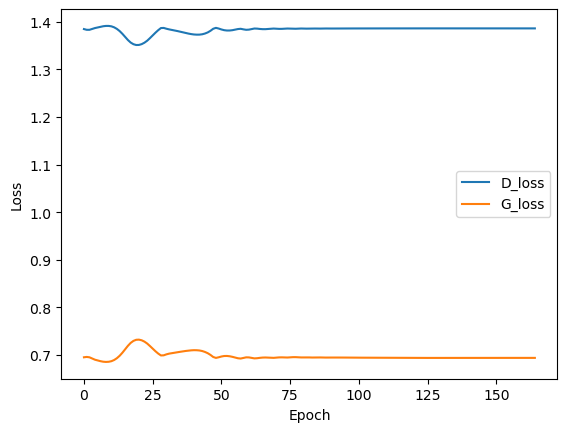

In [30]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

## For Bayesian
opt = {"learning_rate": 0.00016, "epoch": 165, 'bs': 128}

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
print('generator summary: ', generator.summary())
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator, opt)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [31]:
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)
test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

In [32]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_2588\3252645387.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\SUJAN\AppData\Local\Temp\ipykernel_2588\3252645387.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


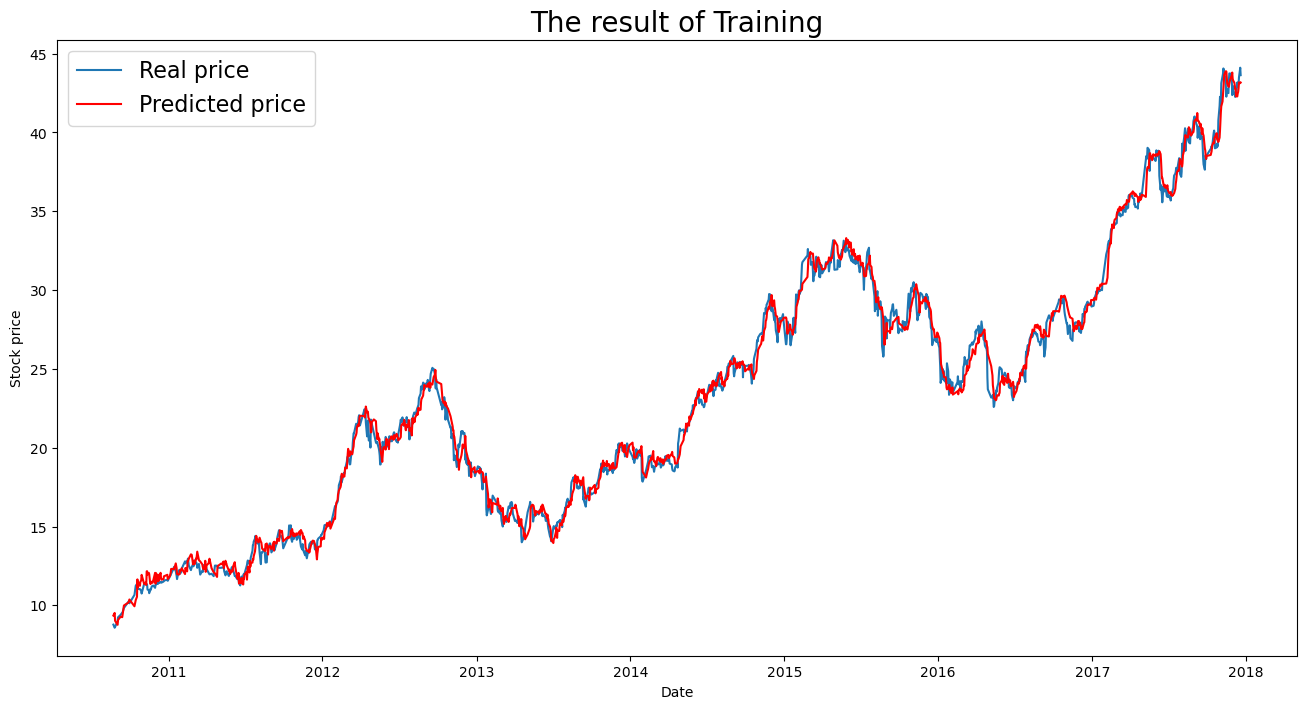

-- Train RMSE --  0.6451635083038677


In [33]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)


In [36]:
rescaled_Real_price

array([[ 8.778571],
       [ 8.581429],
       [ 8.629286],
       ...,
       [43.4925  ],
       [44.105   ],
       [43.634998]])

In [35]:
real_price

,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_price,...,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_price,real_mean
2010-08-23,8.778571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.778571
2010-08-26,NaN,8.581429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.581429
2010-08-27,NaN,NaN,8.629286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.629286
2010-09-02,NaN,NaN,NaN,9.006071,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.006071
2010-09-03,NaN,NaN,NaN,NaN,9.241786,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.241786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,43.067501,NaN,NaN,NaN,NaN,43.067501
2017-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,43.055,NaN,NaN,NaN,43.055000
2017-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.4925,NaN,NaN,43.492500
2017-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.105,NaN,44.105000


In [41]:
rescaled_Real_price.shape

(1467, 1)

In [42]:
rescaled_Predicted_price.shape

(1467, 1)

In [55]:
G_model = tf.keras.models.load_model('gen_model_3_1_164.h5')
output_dim = y_test.shape[1]
# Get predicted data
y_predicted = G_model(X_test)
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)
X_test.shape,y_test.shape

((526, 3, 36), (526, 1))

In [47]:
rescaled_real_y

array([[43.587502],
       [43.752499],
       [43.752499],
       [42.650002],
       [42.77    ],
       [42.307499],
       [43.064999],
       [43.057499],
       [43.2575  ],
       [43.75    ],
       [43.587502],
       [43.5825  ],
       [43.572498],
       [43.82    ],
       [44.272499],
       [44.047501],
       [44.775002],
       [44.814999],
       [44.615002],
       [44.25    ],
       [44.259998],
       [43.555   ],
       [42.7775  ],
       [41.990002],
       [41.7425  ],
       [41.857498],
       [41.945   ],
       [40.125   ],
       [39.122501],
       [40.7575  ],
       [39.884998],
       [38.787498],
       [39.102501],
       [40.677502],
       [41.842499],
       [43.125   ],
       [43.875   ],
       [44.7425  ],
       [44.5975  ],
       [44.529999],
       [43.75    ],
       [44.205002],
       [44.1675  ],
       [43.7575  ],
       [44.235001],
       [44.994999],
       [45.43    ],
       [44.9925  ],
       [44.610001],
       [44.662498],


In [48]:
rescaled_predicted_y

array([[43.44436325],
       [43.61480151],
       [43.49035707],
       [43.61192667],
       [43.58470226],
       [43.2909049 ],
       [42.92192035],
       [42.93438008],
       [43.01495373],
       [43.16355591],
       [43.32064031],
       [43.48656334],
       [43.60601114],
       [43.61788365],
       [43.68028872],
       [43.82439485],
       [44.1158817 ],
       [44.37938675],
       [44.57502972],
       [44.75434622],
       [44.84584936],
       [44.82339945],
       [44.71390841],
       [44.50827278],
       [44.10743908],
       [43.59700296],
       [43.14055281],
       [42.84775601],
       [42.60129213],
       [42.15357542],
       [41.51695238],
       [41.16559127],
       [40.82210784],
       [40.5146497 ],
       [40.25537523],
       [40.41741729],
       [41.14486961],
       [41.90886763],
       [42.73923646],
       [43.31158696],
       [43.78143986],
       [43.96299509],
       [43.94618535],
       [43.89146118],
       [43.9048664 ],
       [43

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_2588\1772117767.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\SUJAN\AppData\Local\Temp\ipykernel_2588\1772117767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


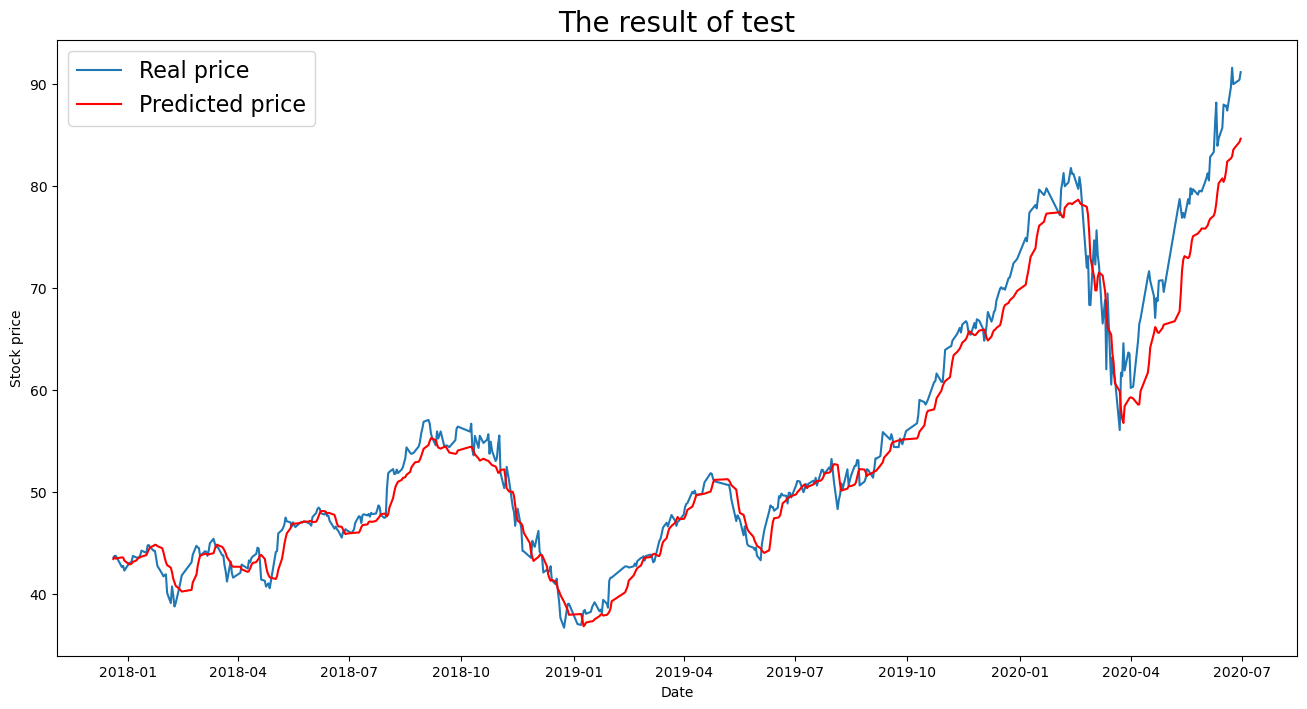

-- RMSE --  2.5399923553686192
--- MAE---  1.7736954985513718


<Figure size 640x480 with 0 Axes>

In [52]:
## Predicted price
predict_result = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=test_predict_index[i:i + output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

## Real price
real_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

#drop 2020
# Input_Before = '2020-01-01'
# predict_result = predict_result.loc[predict_result.index < Input_Before]
# real_price = real_price.loc[real_price.index < Input_Before]

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color='r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of test", fontsize=20)
plt.show()
plt.savefig('test_plot.png')
# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis=1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)
mae = mean_absolute_error(predicted, real)
print("--- MAE--- ", mae)